## Autoencoders - Fashion MNIST dataset👖👕
<br>

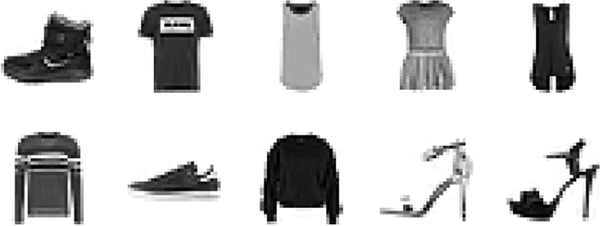

    This notebook will contain the code to start with generative modeling on the MNIST dataset uisng Autoencoders (AE). 

`Autoencoders (AEs)`: These are neural networks which consist of 2 parts - Encoders and decoders. The encoder's function is to generate an embedding from the image whereas the decoder uses the embedding and converts it back to the image.<br><br>
`Generative modelling`: For generating new images, the latent space is used and a random point is fed to the decoder which then uses this point/embedding and generates an image which doesn't belong to the original dataset

<br>

`// Code & comments by Om`

In [1]:
import tensorflow as tf
from tensorflow.keras import datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import importlib

import tensorflow.keras.backend as keras_backend
# Import custom functions
ai_folder_path = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if ai_folder_path not in sys.path:
    sys.path.insert(0, ai_folder_path)
import myutils
importlib.reload(myutils)

<module 'myutils' from '/Users/opmule/Self Development/AI/myutils.py'>

In [2]:
# Import the Fashion MNIST dataset which is prebundled in tensorflow
(x_train, y_train), (x_test, y_test) = datasets.fashion_mnist.load_data()

In [3]:
# Shape of the dataset
print(f"Shape of the training data: {x_train.shape}")
print(f"Shape of the training labels: {y_train.shape}")
print(f"Shape of the test data: {x_test.shape}")
print(f"Shape of the test labels: {y_test.shape}")

Shape of the training data: (60000, 28, 28)
Shape of the training labels: (60000,)
Shape of the test data: (10000, 28, 28)
Shape of the test labels: (10000,)


### Preprocess dataset

    1. Pad the images to (32,32) dimensions. Original images are (28,28)
    2. Scale the images to 0 -> 1 range

In [4]:
# Function to preprocess data
import tensorflow as tf
import numpy as np

def preprocess(imgs):
    """
    Normalize, pad, and reshape images using TensorFlow operations,
    matching the order of the NumPy function.
    """
    imgs = tf.convert_to_tensor(imgs, dtype=tf.float32) # Ensure it's a TF tensor
    imgs = imgs / 255.0
    imgs = tf.pad(imgs, paddings=[[0, 0], [2, 2], [2, 2]], mode='CONSTANT', constant_values=0.0)
    imgs = tf.expand_dims(imgs, -1)

    return imgs.numpy() # Return as NumPy array to match the output type

# ------------- Code from the book -------------
# def preprocess(imgs):
#     """
#     Normalize and reshape the images
#     """
#     imgs = imgs.astype("float32") / 255.0
#     imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
#     imgs = np.expand_dims(imgs, -1)
#     return imgs

In [5]:
x_train = preprocess(x_train)
x_test = preprocess(x_test)

2025-07-22 08:41:13.676291: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-07-22 08:41:13.676474: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-07-22 08:41:13.676479: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1753153873.676838 29851567 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1753153873.676898 29851567 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
# Shape of the dataset
print(f"Training data shape: {x_train.shape}")
print(f"Test data shape: {x_test.shape}")

Training data shape: (60000, 32, 32, 1)
Test data shape: (10000, 32, 32, 1)


### The Encoder
<br>
Using the keras functional API for more flexibility

In [7]:
# Build the encoder model
encoder_input = tf.keras.Input(shape=(32,32,1), name="encoder_input")
x = tf.keras.layers.Conv2D(32, (3,3), strides=2, activation='relu', padding='same')(encoder_input)
x = tf.keras.layers.Conv2D(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2D(128, (3,3), strides=2, activation='relu', padding='same')(x)

# Store the shape before flattening (to be used in the decoder)
shape_before_flattening = keras_backend.int_shape(x)[1:]

x = tf.keras.layers.Flatten()(x)
encoder_output = tf.keras.layers.Dense(2, name='encoder_output')(x)

encoder = tf.keras.models.Model(encoder_input, encoder_output)
encoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96,770 (378.01 KB)

 Trainable params: 96,770 (378.01 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder
<br>
The decoder uses the *`convolutional transpose`* layers which perform the opposite function of the convolutional layers. These are used in decoding the embeddings back to the images

In [8]:
decoder_input = tf.keras.Input(shape=(2,), name='decoder_input')
x = tf.keras.layers.Dense(np.prod(shape_before_flattening))(decoder_input)
# Reshape the vector into a tensor that can be fed as input into the first Conv2DTranspose layer
x = tf.keras.layers.Reshape(shape_before_flattening)(x)
x = tf.keras.layers.Conv2DTranspose(128, (3,3), strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(64, (3,3), strides=2, activation='relu', padding='same')(x)
x = tf.keras.layers.Conv2DTranspose(32, (3,3), strides=2, activation='relu', padding='same')(x)
decoder_output = tf.keras.layers.Conv2D(1, (3,3), strides=1, activation='sigmoid', padding='same', name='decoder_output')(x)

decoder = tf.keras.models.Model(decoder_input, decoder_output)
decoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Conv2D)         │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

### Joining the encoder to the decoder
<br>
We have to define a model which represents the flow of image through an encoder and back out through the decoder

In [9]:
autoencoder = tf.keras.models.Model(encoder_input, decoder(encoder_output))
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_output (Dense)          │ (None, 2)              │         4,098 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 32, 32, 1)      │       246,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 343,043 (1.31 MB)

 Trainable params: 343,043 (1.31 MB)

 Non-trainable params: 0 (0.00 B)

### Generation result differences according to `losses`

<br>
1. Binary crossentropy - Produces slightly blurred images <br>
2. RMSE - Produces pixelates images

#### Loss - Binary crossentropy (blurred images)

In [10]:
# Loss function calculates the loss between the individual pixels of the original image and the reconstructed image
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [11]:
# Training
autoencoder.fit(x_train, x_train, epochs=5, batch_size=100, shuffle=True, validation_data=(x_test, x_test))

Epoch 1/5


2025-07-22 08:41:15.483640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


600/600 ━━━━━━━━━━━━━━━━━━━━ 22s 32ms/step - loss: 0.3588 - val_loss: 0.2606
Epoch 2/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.2580 - val_loss: 0.2563
Epoch 3/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - loss: 0.2551 - val_loss: 0.2540
Epoch 4/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.2526 - val_loss: 0.2531
Epoch 5/5
600/600 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 0.2505 - val_loss: 0.2515


#### Reconstructing the images using the autoencoder

In [12]:
example_images = x_test[:5000]
predictions = autoencoder.predict(example_images)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step


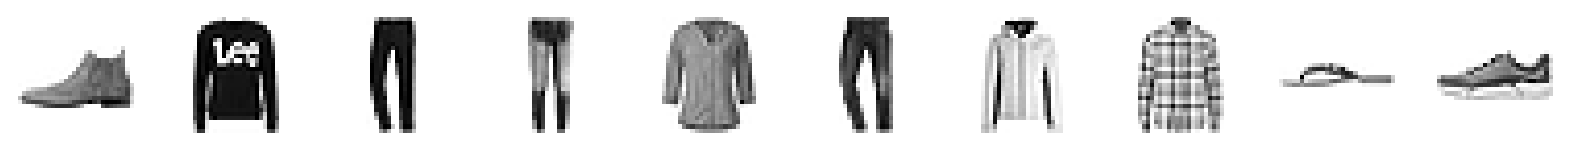

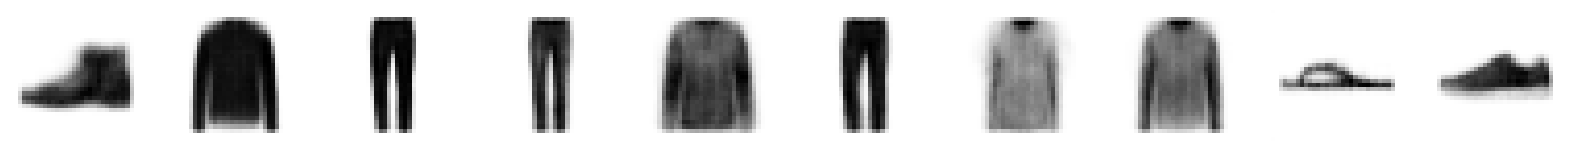

In [13]:
myutils.plot_generated_images(example_images)
myutils.plot_generated_images(predictions)

### Visualizing the latent space

<br>
    Here we would try to visualize how the images are represented in the latent space by the encoder

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


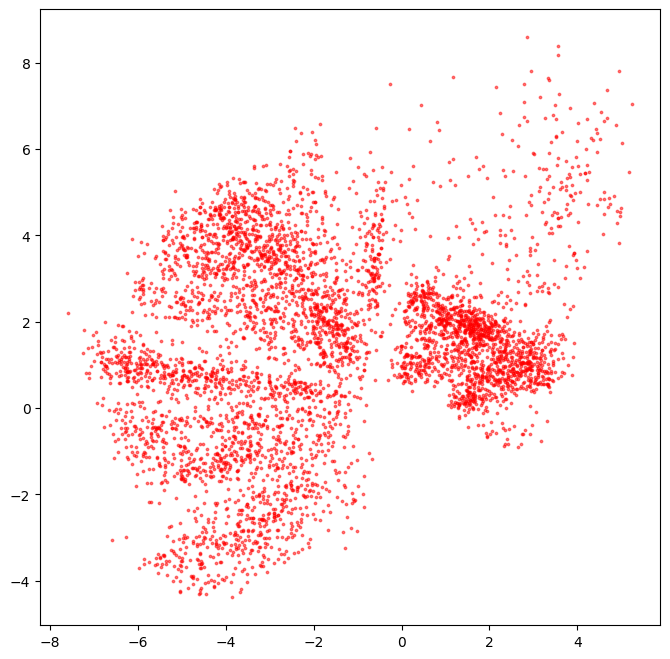

In [14]:
embeddings = encoder.predict(x_test[:5000])

plt.figure(figsize=(8,8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="red", alpha=0.5, s=3)
plt.show()

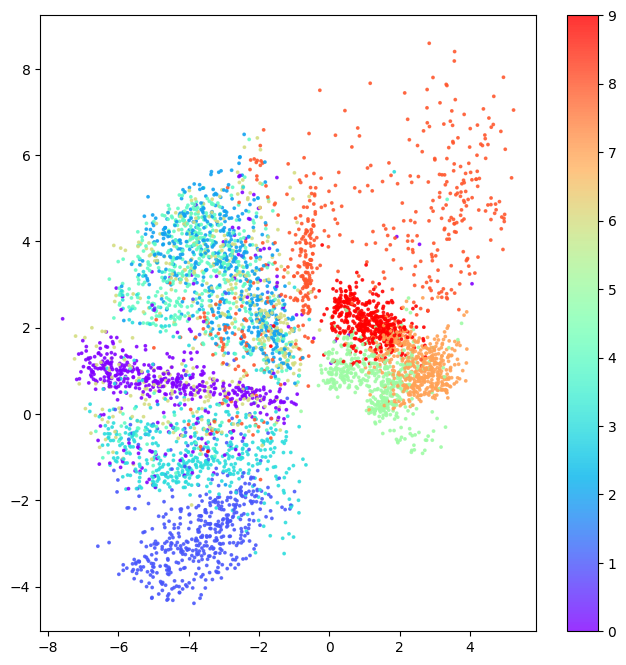

In [15]:
example_labels = y_test[:5000]

plt.figure(figsize=(8,8))
plt.scatter(embeddings[:, 0], embeddings[:, 1], cmap="rainbow", c=example_labels, alpha=0.8, s=3)
plt.colorbar()
plt.show()

### Generate novel images (GenAI)

    This can be done by sampling some points in the latent space and converting them back to the pixel space (images). The decoder model is used to generate novel images which aren't present in the original dataset

In [72]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
# Get points in the range [mins, maxs]
sample = np.random.uniform(mins, maxs, size=(20,2))
print("Sample size:", sample.shape)

reconstructions = decoder.predict(sample)

Sample size: (20, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


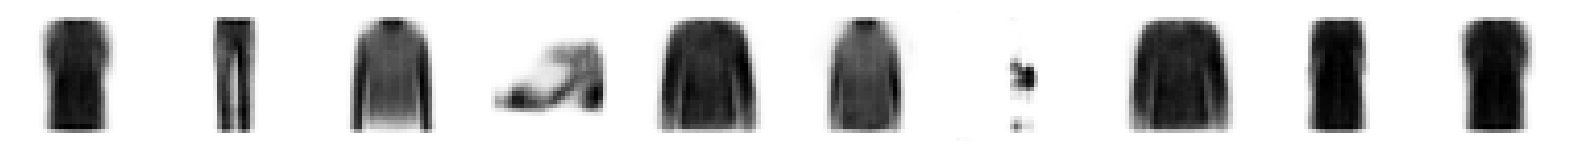

In [53]:
myutils.plot_generated_images(reconstructions)

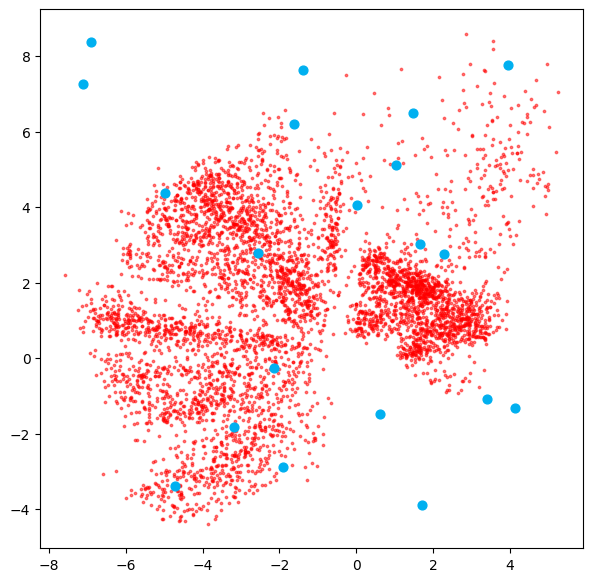

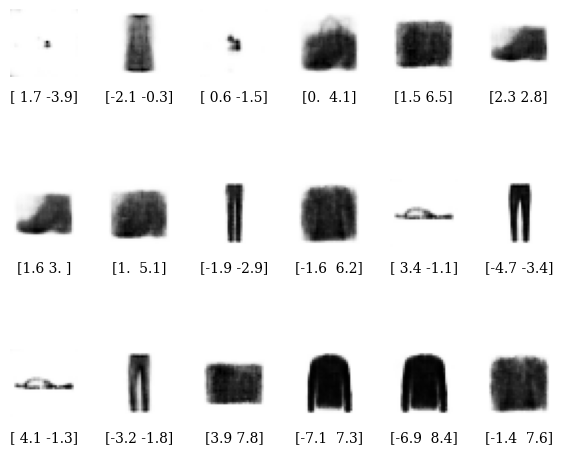

In [73]:
grid_width, grid_height = (6, 3)
figsize = 7

plt.figure(figsize=(figsize, figsize))
# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c="red", alpha=0.5, s=3)
# ... and the newly generated points in the latent space
plt.scatter(sample[:, 0], sample[:, 1], c="#00B0F0", alpha=1, s=40)
plt.show()
# ----------------------------------------------------------------------------

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(sample[i, :], 1)),
        fontsize=10,
        fontfamily="serif",
        ha="center", # Horizontal alignment
        transform=ax.transAxes
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

### Latent space & decoded points

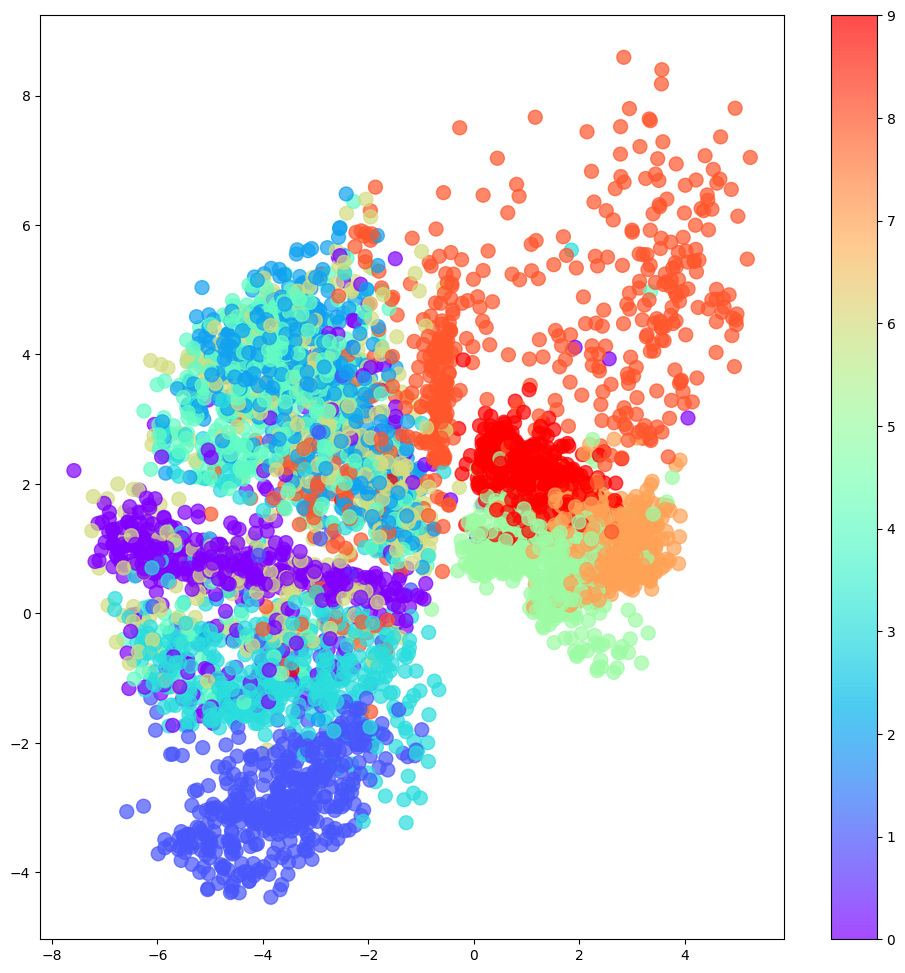

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


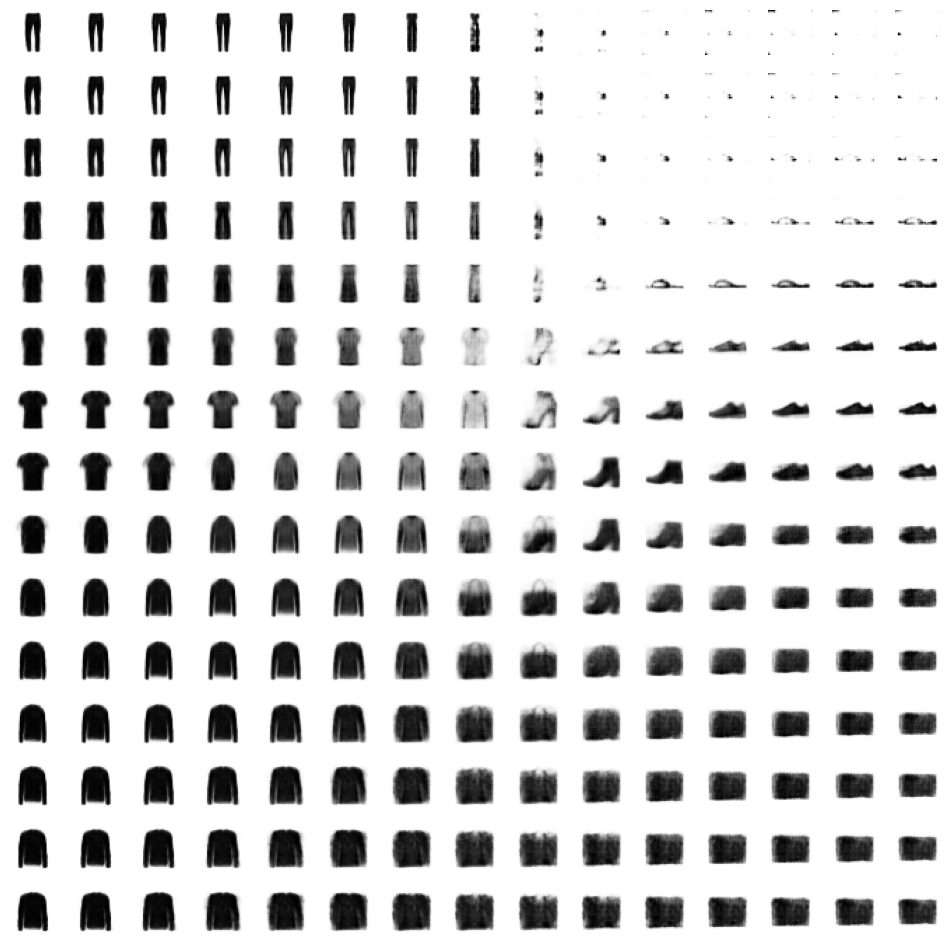

In [107]:
figsize = 12
gridsize = 15
# embeddings = encoder.predict(x_test[:5000])

# c - Important to separate every category by their own color
plt.figure(figsize=(figsize, figsize))
plt.scatter(embeddings[:, 0],
            embeddings[:, 1],
            cmap='rainbow',
            s = 100,
            c = example_labels,
            alpha=0.7
           )
plt.colorbar()
plt.show()
# ------------------------- Images from the decoder -----------------------------
# Generate evenly spaced points from the range [min,max] & generate sets of point (x,y)
x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), num=grid_size)
y = np.linspace(min(embeddings[:, 1]), max(embeddings[:, 1]), num=grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)

# Plot the decoded images
fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconstructions[i, :, :], cmap='Greys')